# Diwersyfikacja portfela inwestycyjnego
## Procedura Quantum Annealing oraz Teoria Grafów

=======================================================================================================================

### Dywersyfikacja portfela jako dobra praktyka inwestycyjna

Dywersyfikacja portfela inwestycyjnego jest dobrą praktyką inwestycyjną, mającą na celu minimalizacje ryzyka poniesienia straty w wyniku tradingu. W myśl zasady "nie wkładaj wszystkich jajek do jednego koszyka" odpowiedzialny portfel powinien składać się nie z jednego lub kilku, ale preferencyjnie z większej ilości papierów. Ważnym aspektem tej praktyki jest obserwacja, że zwiększanie ilości papierów może nie przynieść spodziewanego rezultatu, jeśli będziemy wybierać papiery "podobne" do siebie nawzajem. W tym badaniu jako miarę "podobieństwa" będę przyjmował współczynnik korelacji Pearsona pomiędzy dziennymi zwrotami z wybranych spółek na zadanym okresie czasu (tutaj będą to ostatnie dwa lata). Celem jest wybranie jak największej ilości spółek z zadanego zbioru (indeks Dow Jones) tak, aby korelacja między dowolnymi dwoma nie przekraczała zadanego progu (tutaj wybrałem 0.5). To podejście ma dwie główne zalety:
- korelacje w pobliżu zera oznaczają, że gdy jedna spółka "idzie w dół", to nie będzie przy tym ciągnąć za sobą pozostałych
- ujemne korelacje bliskie -1 oznaczają, że spadek wartości jakiejś spółki z naszego portfela pociągnię za sobą prawdopodobny wzrost wartości innej

### Dywersyfikacja w ujęciu teorii grafów - maximum independent set problem

W ramach niniejszego prjektu chciałbym zaproponować ciekawe, moim zdaniem podejście do problemu dywersyfikacji portfela inwestycyjnego, a mianowicie przełożenie go, na problem *maximum independent set* z matematycznej teorii grafów. 

Graf składa się z wierzchołków (będą one reprezentować poszczególne spółki indeksu) oraz krawędzi łączących wierzchołki. Krawędzie oznaczają pewien konkretny związek pomiędzy dwoma wierzchołkami. W naszym grafie, pomiędzy dwoma wierzchołkami (spółkami) istnieć będzie krawędź wtedy i tylko wtedy, gdy współczynnik korelacji pomiędzy ich dziennymi zwrotami będzie przynajmniej równy 0.6.

Oczywiście, mogą się zdarzyć spółki, które nie będą miały odpowiednio wysokiej korelacji z **żadną** inną spółką. Nie pojawią się one na grafie, ale chcemy je mieć w naszym portfelu!

Ze spółek które znajdą się na grafie chcemy wybrać taki ich podzbiór, żeby spełniał on dwa warunki:

- żadne dwa wierzchołki z podzbioru nie mogą być ze sobą połączone krawędzią
- zbiór ma mieć jak największą liczebność

W teorii grafów takie zagadnienie to właśnie  problem *maximum independent set*, ponieważ niepołączone ze sobą wierzchołki nazywamy wzajemnie *niezależnymi*.

Istnieją klasyczne metody rozwiązywania tego problemu, jednakże w ninejszym projekcie chciałbym zademonstrować rozwiązanie otrzymane przy pomocy algorytmu Quantum Annealing, zaimplementowanego na maszynie firmy D-wave

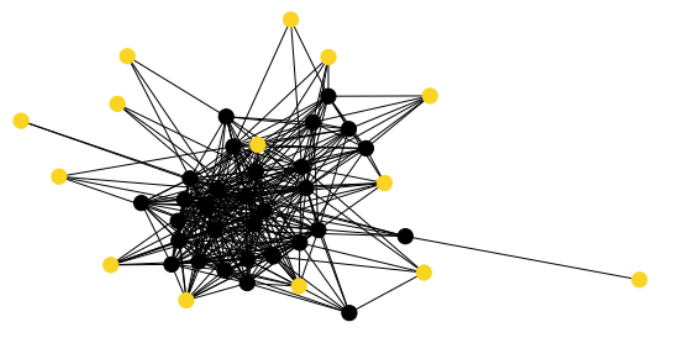

*Przykład rozwiązania problemu MIS - żółte wierzchołki to takie, które nie mają powiązania z żadnym innym żółtym wierzchołkiem*

### Algorytm Quantum Annealing

Procedura *quantum annealing* pozwala znaleźć globalne minimum zadanej funkcji celu na zadanym zbiorze rozwiązań. 

Czynnikiem, który pozwala temu algorytmowi "uciec" z pułapki lokalnego minimum jest zjawisko tunelowania kwantowego, które polega na tym, że dana funkcja falowa może, z pewnym prawdopodobieństwem, propagować się pomimo obecności bariery potencjału. Klasycznie, taka sytuacja nie może mieć miejsca (przypomina to sytuację, w której piłeczka ping-pongowa spontanicznie wyskakuje z miski, pomimo że nikt jej nawet nie dotknął), jest to jednak jak najbardziej realne i obserwowalne zjawisko, opisywane przez mechanikę kwantową. 
W naszym przypadku oznacza to, że dany układ qubitów będzie mógł z pewnym prawdopodobieństwem ewoluować do stanu, który ma wyższą wartość funkcji celu (co nie jest dopuszczalne w przypadku zachłannych algorytmów), dzięki czemu może opuszczać lokalne minima i dalej eksplorować przestrzeń rozwiązań.

Algorytm zaczyna od stanu splątanych qubitów, a następnie pozwala systemowi ewoluować, w obecności odpowiednio dobranych pól elektro-magentycznych (które poprzez "uginanie" składowych spinu qubitów faworyzują korzystną ewolucję stanu) tak, by na koniec procedury układ znalazł się w stanie bliskim najniższej energii (ang. *ground state*). 

Stan ten będzie w przybliżeniu odpowiadał rozwiązaniu, które minimalizuje funkcję celu.

####  Dwave quantum annealer

W 2007 roku firma D-wave uruchomiła komputer kwantowy przeznaczony do implementacji procedury quantum annealing. Biblioteka dwave-ocean-sdk umożliwi nam użycie mocy obliczeniowej chipu QPU tego komputera do przeprowadzenia optymalizacji, za pomocą której rozwiążemy problem maximum independent set naszego portfela inwestycyjnego.

####  Problemy klasy QUBO

Urządzenie D-wave zostało stworzone do rozwiązywania problemów znanych w matematyce jako QUBO. Odpowiednie literki tego skrótu oznaczają:
- Quadratic (ponieważ najwyższa potęga wielomianu którego dotyczy problem to 2)
- Unconstraint (funkcja celu nie ma formalnie określonych ograniczeń)
- Binary (rozważamy problem zero-jedynkowy)
- Optimization (minimalizujemu lub maksymalizujemy funkcję celu)

Problem z teorii grafów, który będziemy rozwiązywać, można przetłumaczyć na problem klasy *QUBO*. 


W kwesti punktu *Binary* jest to bardzo proste - wybrany wierzchołek albo jest, albo go nie ma w zbiorze którego szukamy.

Punkt *Optimization* również jest jasny - chcemy maksymalizować liczebność zbioru wynikowego.

W punkcie *Constraint* mamy wszak ograniczenie - wybrane punkty nie mogą mieć ze sobą krawędzi. Możemy jednak zintegralizować to ograniczenie, włączając je do funkcji celu. Robimy to poprzez stworzenie iloczynów, które liczymy przy każdej krawędzi. Jeśli oba wierzchołki, które łączy krawędź wchodzą do zbioru wynikowego, to iloczyn taki ma wartość 1 .
Jeśli choć jeden z nich nie wchodzi - iloczyn ma wartość 0 (patrz rysunek poniżej). 
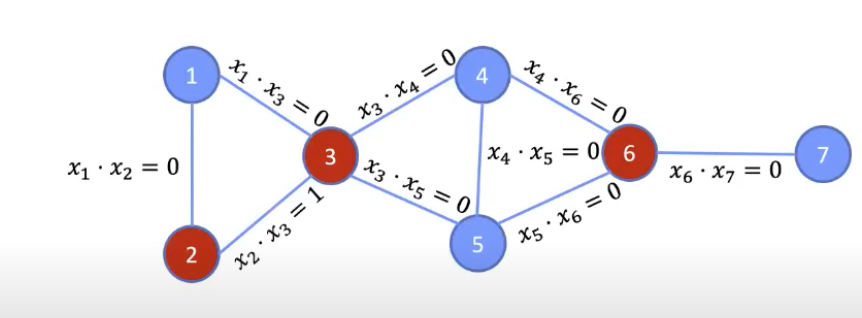
Chcemy, żeby suma wszystkich iloczynów w grafie równała się 0.
Internalizacja tego ograniczenia dokonuje się za pomocą metody Lagrange'a - funkcja celu ma teraz postać:

$                                -obj + \gamma (ograniczenie) $
                                
gdzie obj jest oryginalną postacią naszej funkcji celu (mnożymy przez -1, żeby uzyskać dla oby składników problem minimalizacji), a $ \gamma $ to współczynnik Lagrange'a. Konkretnie zaś równanie to przedstawia się następująco:

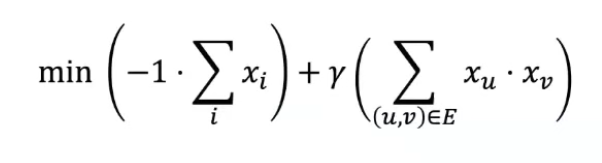
                                            
W dalszej części zadania użyjemy funkcji *maximum_independent_set()* z pakietu dwave_networkx. Funkcja ta sformuuje problem dla naszego grafu w sposób podany powyżej, a następnie przekaże go do maszyny D-wave, która zwróci rozwiązanie w postaci listy wierzchołków, które będą możliwym i (blisko) optymalnym rozwiązaniem naszego problemu.

================================================================================================================

## Pobieranie notowań

In [1]:
from pytickersymbols import PyTickerSymbols
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
from concurrent.futures import ThreadPoolExecutor as Executor  # przyspieszymy ściąganie, kolejność nie gra dla nas roli

*pytickersymbols* - biblioteka umożliwiająca łatwe pobieranie m.in składów indeksów giełdowych


dokumentacja: https://pypi.org/project/pytickersymbols/


instalacja:

```bash
pip install pytickersymbols
```


In [2]:
class Scraper:
    """Zadaniem tego obiektu jest pobieranie notowań spółek z określonego zestawu za zadany okres czasu
    oraz zapisywanie ich do formatu pandasowej ramki danych"""
    
    def __init__(self, start_date, end_date):
        self.start = start_date
        self.end = end_date
        self.all_dfs = []
        self.data = pd.DataFrame()
        self.tickers = []

    def pull_tickers(self, index="Dow Jones"):
        """Funkcja ściąga aktualny skład wskazanego indeksu i zapisuje do listy tickerów. Dostępne opcje to 'Dow Jones',
        'S&P 500' oraz 'DAX'."""
        stock_data = PyTickerSymbols()
        
        if index == "Dow Jones":
            tickers = stock_data.get_dow_jones_nyc_yahoo_tickers()
            
        elif index == "S&P 500":
            tickers == stock_data.get_sp_500_nyc_yahoo_tickers()
            
        elif index == "DAX":
            tickers = stock_data.get_dax_frankfurt_yahoo_tickers()
            
        else:
            raise ValueError(f"Brak wsparcia dla indeksu {index}. Możliwe opcje: 'Dow Jones', 'S&P 500', 'DAX'")
            
        self.tickers = list(tickers)
        
    def set_tickers(self, tickers):
        """Obiekt dopuszcza podanie customowego zestawu tickerów do analizy"""
        self.tickers = tickers        

    def get_time_series(self, ticker, provider="yahoo"):
        """Dla danego tickera funkcja pobierze notowania na zadany w konstruktorze okres czasu"""
        df = pdr.DataReader(ticker, provider, self.start, self.end)
        df = df["Adj Close"]  # bierzemy tylko kolumnę Adjusted Close
        df = df.rename(ticker)
        self.all_dfs.append(df)  # obiekty zbieramy do listy, która posłuży potem do utworzenia jednej tabeli zbiorczej

    def scrape_data(self):
        with Executor(max_workers=30) as executor:  # używamy concurrent computingu żeby przyspieszyć ściąganie danych
            executor.map(self.get_time_series, self.tickers)
        self.data = self.merge_data_frames(self.all_dfs)
        self.data = self.data.sort_index(axis=1)  # sortujemy nazwy kolumn alfabetycznie (trafiają w losowym porządku)

    @staticmethod
    def merge_data_frames(dfs) -> pd.DataFrame:
        df = pd.concat(dfs, axis=1)  # funkcja pandas.concat bierze listę obiektów typu DataFrame i tworzy jedną ramkę danych
        return df

In [3]:
end = dt.datetime.now()  # aktualna data
start = end - dt.timedelta(days=365*2)  # cofamy się o dwa lata
scraper = Scraper(start, end)
scraper.pull_tickers()
scraper.scrape_data()
df = scraper.data  # zapisujemy efekty pracy Scrapera do obiektu df: pandas.DataFrame

In [4]:
df

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-21,59.156300,191.879166,115.614182,327.192505,126.430717,144.550003,44.510315,105.037743,129.484222,42.357841,...,75.624863,135.627258,94.523727,114.061348,135.022537,236.506012,174.294968,55.680580,50.468391,115.877388
2019-10-22,59.021027,193.675705,115.186882,333.063110,127.826668,142.330002,44.660583,106.109650,131.611481,42.088169,...,72.743744,133.608978,93.914665,117.030701,123.833290,241.897003,168.792358,55.698910,51.143280,115.722557
2019-10-23,59.813023,192.247940,113.128067,336.522217,129.404297,145.130005,44.190968,106.271790,130.349045,42.456730,...,74.148514,134.461365,90.692482,117.816147,125.745750,240.268097,169.246811,55.799736,50.440662,115.499977
2019-10-24,59.911404,192.002106,113.050385,340.524872,127.979652,148.119995,43.589863,105.911476,129.484222,44.470345,...,73.889023,137.106705,89.886940,119.530708,125.051155,237.078079,174.028244,55.524769,50.338966,115.258034
2019-10-25,60.649292,191.992630,114.846985,335.860046,133.601761,150.490005,44.050091,106.893295,130.120407,45.378265,...,73.602699,137.880692,89.317162,118.055595,124.099716,237.465897,175.697784,55.332291,51.235733,115.199966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-13,140.910004,203.610001,168.720001,221.779999,188.940002,284.410004,54.619999,107.790001,172.960007,56.910000,...,78.949997,296.309998,156.300003,142.440002,156.389999,403.549988,222.460007,51.349998,47.259998,138.369995
2021-10-14,143.759995,206.779999,171.509995,217.440002,194.330002,290.019989,55.650002,108.809998,174.410004,58.740002,...,78.330002,302.750000,157.139999,144.050003,156.690002,420.359985,225.179993,51.919998,50.770000,139.869995
2021-10-15,144.839996,207.839996,175.809998,217.039993,199.020004,291.660004,55.250000,109.610001,176.460007,58.959999,...,78.330002,304.209991,158.009995,144.419998,155.639999,428.070007,230.990005,52.270000,48.919998,140.550003


In [5]:
# do testów można wczytywać pobrane wcześniej i zapisane do csv dane
# df.to_csv("temp.csv")
# df1 = pd.read_csv("temp.csv")
# df1 = df1.set_index("Date")

## Badanie korelacji dziennych zwrotów spółek

In [6]:
df_ret = df.pct_change()  # metoda pct_change klasy pandas.DataFrame tworzy ramkę danych z "dziennymi" zmianami kursów

Dokumentacja metody pct_change: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html

In [7]:
df_ret

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-22,-0.002287,0.009363,-0.003696,0.017942,0.011041,-0.015358,0.003376,0.010205,0.016429,-0.006367,...,-0.038098,-0.014881,-0.006443,0.026033,-0.082869,0.022794,-0.031571,0.000329,0.013373,-0.001336
2019-10-23,0.013419,-0.007372,-0.017874,0.010386,0.012342,0.019673,-0.010515,0.001528,-0.009592,0.008757,...,0.019311,0.006380,-0.034310,0.006711,0.015444,-0.006734,0.002692,0.001810,-0.013738,-0.001923
2019-10-24,0.001645,-0.001279,-0.000687,0.011894,-0.011009,0.020602,-0.013602,-0.003390,-0.006635,0.047427,...,-0.003500,0.019674,-0.008882,0.014553,-0.005524,-0.013277,0.028251,-0.004928,-0.002016,-0.002095
2019-10-25,0.012316,-0.000049,0.015892,-0.013699,0.043930,0.016001,0.010558,0.009270,0.004913,0.020416,...,-0.003875,0.005645,-0.006339,-0.012341,-0.007608,0.001636,0.009594,-0.003467,0.017815,-0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-13,-0.004240,0.008519,-0.035390,-0.008006,-0.005160,0.019391,0.006264,0.005973,-0.000982,-0.014375,...,-0.008041,0.011711,0.019237,0.002322,-0.000575,0.000769,-0.007097,0.000390,-0.003374,-0.007246
2021-10-14,0.020226,0.015569,0.016536,-0.019569,0.028528,0.019725,0.018858,0.009463,0.008383,0.032156,...,-0.007853,0.021734,0.005374,0.011303,0.001918,0.041655,0.012227,0.011100,0.074270,0.010841
2021-10-15,0.007513,0.005126,0.025071,-0.001840,0.024134,0.005655,-0.007188,0.007352,0.011754,0.003745,...,0.000000,0.004822,0.005536,0.002569,-0.006701,0.018341,0.025802,0.006741,-0.036439,0.004862


In [8]:
corr_matrix = df.corr()  # tworzymy macierz korelacji
corr_matrix

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
AAPL,1.000000,0.512209,0.687402,-0.207640,0.830050,0.907843,0.639534,0.138155,0.759517,0.769088,...,0.071422,0.947995,0.942046,0.892143,0.710213,0.904238,0.874281,0.359619,0.026144,0.905126
AMGN,0.512209,1.000000,0.257683,-0.114180,0.507008,0.422280,0.314147,0.130113,0.404580,0.491434,...,0.194869,0.444038,0.401607,0.457640,0.323594,0.499010,0.530824,0.491766,0.036093,0.487484
AXP,0.687402,0.257683,1.000000,0.403030,0.847683,0.582637,0.892580,0.728299,0.862238,0.884252,...,0.267594,0.770296,0.792579,0.635963,0.935609,0.849143,0.864900,0.288344,0.624836,0.491986
BA,-0.207640,-0.114180,0.403030,1.000000,0.149434,-0.207795,0.270203,0.781934,0.346759,0.347358,...,0.461433,-0.193938,-0.025327,-0.073713,0.446688,-0.038403,0.095057,0.286760,0.763333,-0.318729
CAT,0.830050,0.507008,0.847683,0.149434,1.000000,0.683512,0.741691,0.498588,0.925162,0.959629,...,0.038877,0.812384,0.858124,0.734905,0.906883,0.890914,0.858680,0.434549,0.460289,0.727155
CRM,0.907843,0.422280,0.582637,-0.207795,0.683512,1.000000,0.476549,0.031415,0.595218,0.663316,...,0.159441,0.855081,0.853509,0.903371,0.579278,0.785853,0.792093,0.394252,-0.123877,0.863672
CSCO,0.639534,0.314147,0.892580,0.270203,0.741691,0.476549,1.000000,0.693805,0.749704,0.763112,...,0.207720,0.781137,0.704047,0.544856,0.825254,0.817398,0.792772,0.141380,0.579337,0.448342
CVX,0.138155,0.130113,0.728299,0.781934,0.498588,0.031415,0.693805,1.000000,0.632604,0.635709,...,0.401411,0.239336,0.288297,0.134788,0.714268,0.394125,0.461362,0.255118,0.856669,-0.038803
DIS,0.759517,0.404580,0.862238,0.346759,0.925162,0.595218,0.749704,0.632604,1.000000,0.938790,...,0.158290,0.726968,0.825342,0.644914,0.937814,0.797858,0.814116,0.414250,0.571395,0.608738
DOW,0.769088,0.491434,0.884252,0.347358,0.959629,0.663316,0.763112,0.635709,0.938790,1.000000,...,0.228651,0.743824,0.832586,0.733872,0.944189,0.847916,0.858749,0.530063,0.548464,0.661931


## Układ korelacji jako problem z teorii grafów

In [9]:
assets = df.columns

In [10]:
import networkx as nx  # biblioteka do pracy z grafami

In [11]:
nodes = []
for i in assets:
    for j in assets:
        if i != j:
            corr = corr_matrix.loc[i, j]
            if corr >= 0.5:  # tworzymy połączenie wtedy, gdy wsp. korelacji jest przynajmniej równy 0.5
                pair = (i, j)
                if (j, i) not in nodes:  # nie chcemy duplikować połączeń w grafie
                    nodes.append(pair)

all_tickers = set(assets)
chosen = set()
for i in nodes:
    _, _1 = i
    chosen.add(_); chosen.add(_1)  # zbieramy unikatowe tickery, które znalazły się w grafie

diff = all_tickers - chosen  # różnica wskaże nam tickery, które nie znalazły się w grafie
diff

set()

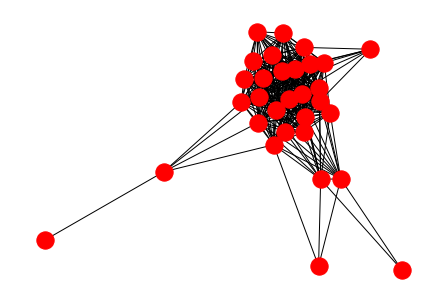

In [12]:
G = nx.Graph()  # inicjalizacja obiektu Graph
G.add_edges_from(nodes)  # dodajemy nasze punkty i połączenia
nx.draw(G, node_color="r")  # wizualizacja grafu

## Wybór spółek do zdywersyfikowanego portfela

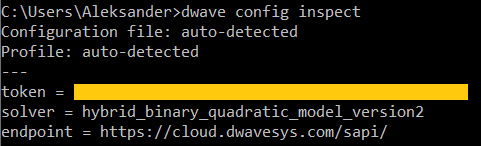

Listę dostępnych solverów można otrzymać wykonując:
```python
from dwave.cloud import Client
client = Client.from_config(token=my_secret_token)
client.get_solvers()   
```

Do celów niniejszej analizy użyto solvera *hybrid_binary_quadratic_model_version2*.

In [13]:
import dwave_networkx as dnx
# from dwave.system.samplers import DWaveSampler
from dwave.system import LeapHybridSampler  # hybrydowy sampler
# from dwave.system.composites import EmbeddingComposite

In [14]:
#my_sampler = EmbeddingComposite(DWaveSampler())
my_sampler = LeapHybridSampler()
# my_sampler = dimod.SimulatedAnnealingSampler()

In [15]:
S = dnx.maximum_independent_set(G, sampler=my_sampler, label="QPD-1")

In [16]:
S  # wybrane przez algorytm spółki

['AMGN', 'AXP', 'BA', 'INTC', 'VZ', 'WMT']

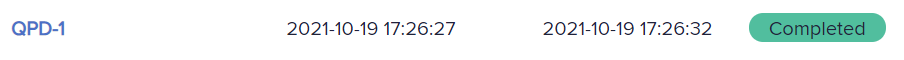

## Wizualizacja wyników

In [17]:
"""Kolorujemy nasz wyjściowy graf - wybrane przez algorytm spółki będą niebieskie, reszta pozostanie na czerwono"""
color_map = []
for node in G:
    if node in S:
        color_map.append("blue")
    else:
        color_map.append('red')

In [18]:
import matplotlib.pyplot as plt

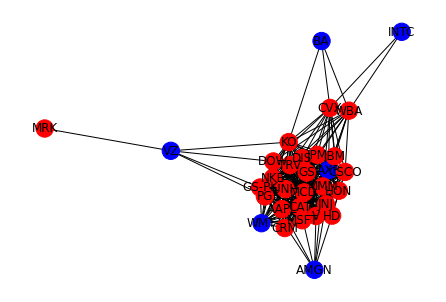

In [19]:
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [20]:
G.has_edge("VZ", "BM")

False

In [21]:
dnx.is_independent_set(G, S)

True

## Ostateczny wynik

In [22]:
tickers_for_portfolio = S + list(diff)  # portfel po uwzględnieniu spółek, które nie znalazły się w grafie
tickers_for_portfolio

['AMGN', 'AXP', 'BA', 'INTC', 'VZ', 'WMT']

## Co dalej...

- Mamy spółki, ale nie znamy proporcji
- Symulacja portfeli w poszukiwaniu najwyższego Sharpe Ratio (albo optymalizacja?)
- Po paru miesiącach możemy zweryfikować, na ile opłacalna była wskazana przez program inwestycja
- Możemy też porównać ten wynik z wynikiem jaki otrzymalibyśmy stosując klasyczne procedury
- Dow Jones to mały indeks - może warto wypróbować większy? (np. S&P 500)